This notebook shows how to apply CNN to predict the global temperature map, based on the 1-D time series of CO2 & CH4.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler

from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ds1 = xr.open_dataset("lightning_era5_merged_july2024.nc")

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

# Training set
d0_train = '2024-07-01T00:00:00'
d1_train = '2024-07-21T00:00:00'
X_train_xr = ds1.sel(time=slice(d0_train,d1_train))
y_train_xr = ds1.sel(time=slice(d0_train,d1_train))

# Test set
d0_test = '2024-07-21T00:00:00'
d1_test = '2024-07-31T00:00:00'
X_test_xr = ds1.sel(time=slice(d0_test,d1_test))
y_test_xr = ds1.sel(time=slice(d0_test,d1_test))

X_train = np.stack((X_train_xr['convective_available_potential_energy'].data,
                   X_train_xr['total_precipitation'].data,
                   X_train_xr['2m_temperature'].data,
                   X_train_xr['total_column_water_vapour'].data,
                   X_train_xr['vertical_velocity'].data),
                  axis=1)

X_test = np.stack((X_test_xr['convective_available_potential_energy'].data,
                   X_test_xr['total_precipitation'].data,
                   X_test_xr['2m_temperature'].data,
                   X_test_xr['total_column_water_vapour'].data,
                   X_test_xr['vertical_velocity'].data),
                 axis=1)

y_train = y_train_xr['lightning_density'].data
y_test = y_test_xr['lightning_density'].data

# Convert to binary classification: 1 if lightning present, 0 otherwise
y_train = (y_train > 0).astype(np.float32)
y_test = (y_test > 0).astype(np.float32)

In [4]:
print(f"Data shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Target spatial dimensions: {y_train.shape[1]} x {y_train.shape[2]}")
print(f"Lightning presence: {100 * y_train.mean():.2f}% of pixels have lightning")

Data shapes - X_train: (473, 5, 141, 281), y_train: (473, 141, 281)
Target spatial dimensions: 141 x 281
Lightning presence: 1.02% of pixels have lightning


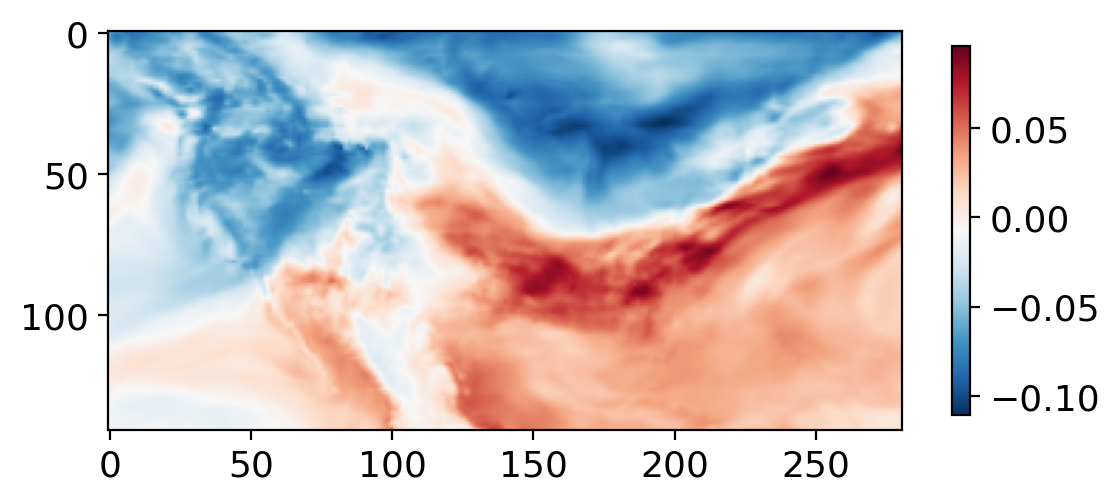

In [26]:
plt.imshow(np.flip(X_train[0,3,:,:],axis=0),cmap='RdBu_r')
plt.colorbar(shrink=0.5)

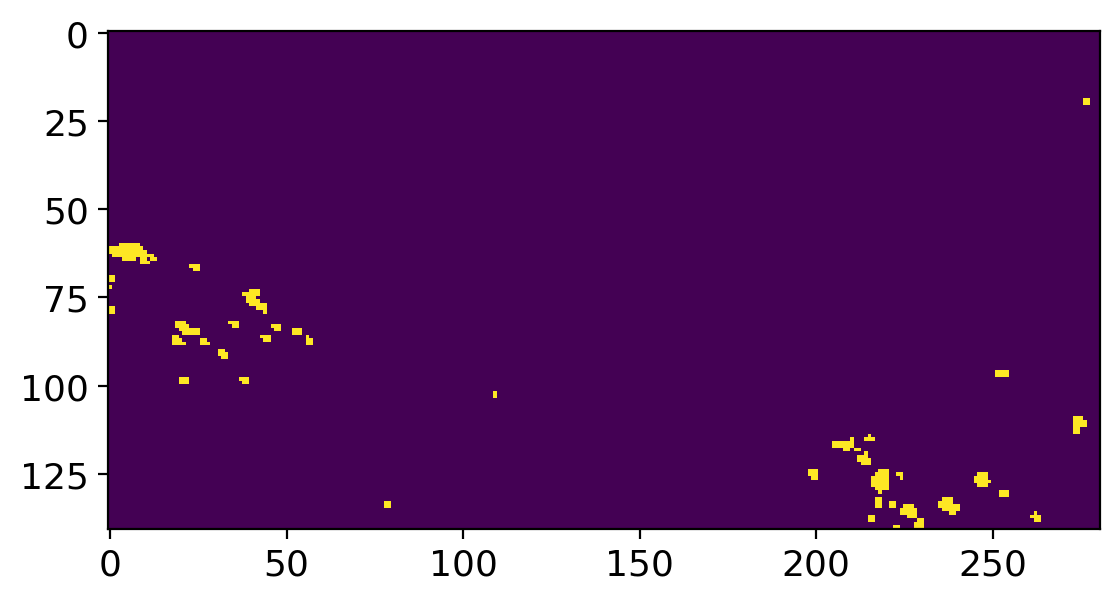

In [6]:
plt.imshow(np.flip(y_train[0],axis=0))#,cmap='RdBu_r')
#plt.colorbar(shrink=0.5)

#### Data normalization

Let's normalize the input predictors by there mean & standard deviation

In [7]:
# Standardization
mean = np.mean(X_train,axis=(0,2,3),keepdims=True).astype(np.float32)
std = np.std(X_train,axis=(0,1,3),keepdims=True).astype(np.float32)

X_train = ((X_train - mean) / std).astype(np.float32)
X_test = ((X_test - mean) / std).astype(np.float32)

# Convert to PyTorch datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Add channel dim
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) # Add channel dim

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

print(f"Shapes: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

# DIAGNOSTICS: Check binary target distribution
print(f"\nBinary target (y_train) statistics:")
print(f"  Class 0 (no lightning): {100 * (y_train == 0).sum() / y_train.size:.2f}%")
print(f"  Class 1 (lightning): {100 * (y_train == 1).sum() / y_train.size:.2f}%")
print(f"  Total pixels: {y_train.size:,}")

Shapes: X_train: (473, 5, 141, 281), X_test: (218, 5, 141, 281), y_train: (473, 141, 281), y_test: (218, 141, 281)

Binary target (y_train) statistics:
  Class 0 (no lightning): 98.98%
  Class 1 (lightning): 1.02%
  Total pixels: 18,740,733


### 2. Define the CNN architecture


The CNN architecture used here consists of several upsampling blocks. 

We set the dimensions of the hidden layers (i.e., number of neurons) in order to reach the size of the target maps (96x144) in a proportional way (in particular by doubling the dimensions in each upsampling block) through the various upsampling blocks. 

<!-- 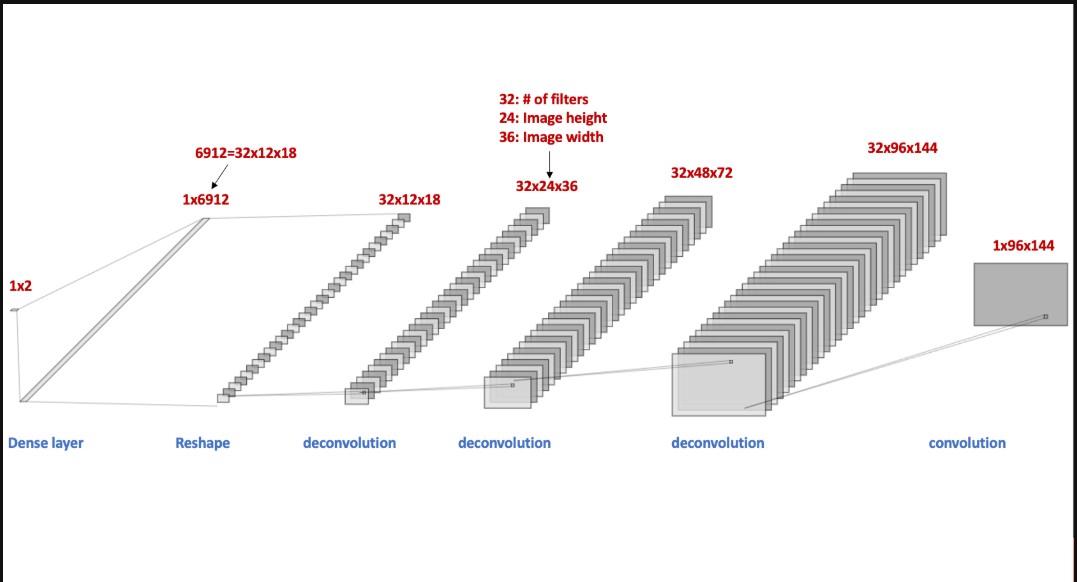 -->

Here are the hyperparameters for the CNN training. Note that these hyperparameters here are for demonstration purposes only and they are not optimized.  

In [8]:
# Hyperparameters
n_filters = 16  # number of filters - reduced from 32
n_neurons = 16  # number of neurons in dense layer - reduced from 32
activation = 'ReLU' # activation function
kernel_size = 3
learning_rate = 0.001
minibatch_size = 32  # reduced from 64
num_epochs = 50

In [9]:
class SpatialCNN(nn.Module):
    
    def __init__(self, in_channels=2, n_filters=16, activation='ReLU'):
        super(SpatialCNN, self).__init__()
        
        act = getattr(nn, activation)
        
        # Encoder path - extract features
        self.conv1 = nn.Conv2d(in_channels, n_filters, kernel_size=3, padding=1)
        self.act1 = act(inplace=True)
        
        self.conv2 = nn.Conv2d(n_filters, n_filters*2, kernel_size=3, padding=1)
        self.act2 = act(inplace=True)
        
        self.conv3 = nn.Conv2d(n_filters*2, n_filters*2, kernel_size=3, padding=1)
        self.act3 = act(inplace=True)
        
        # Decoder path - reduce to output
        self.conv4 = nn.Conv2d(n_filters*2, n_filters, kernel_size=3, padding=1)
        self.act4 = act(inplace=True)
        
        self.conv5 = nn.Conv2d(n_filters, n_filters//2, kernel_size=3, padding=1)
        self.act5 = act(inplace=True)
        
        # Final output layer with sigmoid for binary classification
        self.conv_out = nn.Conv2d(n_filters//2, 1, kernel_size=1)
        
    def forward(self, x):
        # Process spatial data directly
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.act4(self.conv4(x))
        x = self.act5(self.conv5(x))
        x = self.conv_out(x)
        # Sigmoid is applied in BCEWithLogitsLoss for numerical stability
        return x

In [10]:
# Create model
model_mse = SpatialCNN(in_channels=X_train.shape[1], n_filters=n_filters, activation=activation)

print("\nModel:")
print(model_mse)
print(f"\nTotal parameters: {sum(p.numel() for p in model_mse.parameters()):,}")


Model:
SpatialCNN(
  (conv1): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU(inplace=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU(inplace=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU(inplace=True)
  (conv5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU(inplace=True)
  (conv_out): Conv2d(8, 1, kernel_size=(1, 1), stride=(1, 1))
)

Total parameters: 20,417


In [68]:
# Test forward pass
with torch.no_grad():
    test_input = X_train_tensor[:2]
    test_output = model_mse(test_input)
    print(f"\nTest forward pass:")
    print(f"  Input shape: {test_input.shape}")
    print(f"  Output shape: {test_output.shape}")
    print(f"  Expected: (2, 1, {y_train.shape[1]}, {y_train.shape[2]})")


Test forward pass:
  Input shape: torch.Size([2, 5, 141, 281])
  Output shape: torch.Size([2, 1, 141, 281])
  Expected: (2, 1, 141, 281)


### 3. Train & save the CNN model

In [11]:
def pytorch_train(model, optimizer, criterion, device, use_amp=True):
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 20
    
    train_losses = []
    val_losses = []

    # Mixed precision training
    scaler = GradScaler() if use_amp and device.type == 'cuda' else None
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            
            if scaler is not None:
                with autocast():
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                
                if scaler is not None:
                    with autocast():
                        outputs = model(batch_X)
                        loss = criterion(outputs, batch_y)
                else:
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # Early stopping       
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        # Clear cache periodically
        if device.type == 'cuda' and (epoch + 1) % 5 == 0:
            torch.cuda.empty_cache()
    
    return train_losses, val_losses

In [71]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

optimizer_mse = torch.optim.Adam(model_mse.parameters(), lr=learning_rate)
# Loss function
# mse_loss = nn.MSELoss()
# Use Binary Cross Entropy loss for binary classification
bce_loss = nn.BCEWithLogitsLoss()

# Sanity check - what does model predict initially?
model_mse.to(device)
model_mse.eval()
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    sample_X, sample_y = sample_batch[0].to(device), sample_batch[1].to(device)
    sample_pred = model_mse(sample_X)
    sample_pred_prob = torch.sigmoid(sample_pred)  # Convert logits to probabilities
    print(f"\nInitial predictions check:")
    print(f"  True y - min: {sample_y.min():.3f}, max: {sample_y.max():.3f}, mean: {sample_y.mean():.3f}")
    print(f"  Pred probs - min: {sample_pred_prob.min():.3f}, max: {sample_pred_prob.max():.3f}, mean: {sample_pred_prob.mean():.3f}")
    print(f"  Initial BCE Loss: {bce_loss(sample_pred, sample_y).item():.6f}")


Initial predictions check:
  True y - min: 0.000, max: 1.000, mean: 0.009
  Pred probs - min: 0.494, max: 0.508, mean: 0.498
  Initial BCE Loss: 0.688468


In [72]:
train_losses_mse, val_losses_mse = pytorch_train(model_mse.to(device), optimizer_mse, criterion = bce_loss, device = device)

Epoch 1/50, Train Loss: 0.650839, Val Loss: 0.548543
Epoch 5/50, Train Loss: 0.072978, Val Loss: 0.064847
Epoch 10/50, Train Loss: 0.057761, Val Loss: 0.054898
Epoch 15/50, Train Loss: 0.056656, Val Loss: 0.053780
Epoch 20/50, Train Loss: 0.055583, Val Loss: 0.052958
Epoch 25/50, Train Loss: 0.055186, Val Loss: 0.052527
Epoch 30/50, Train Loss: 0.054756, Val Loss: 0.052245
Epoch 35/50, Train Loss: 0.054373, Val Loss: 0.051989
Epoch 40/50, Train Loss: 0.054269, Val Loss: 0.051647
Epoch 45/50, Train Loss: 0.054070, Val Loss: 0.051435
Epoch 50/50, Train Loss: 0.053797, Val Loss: 0.051373


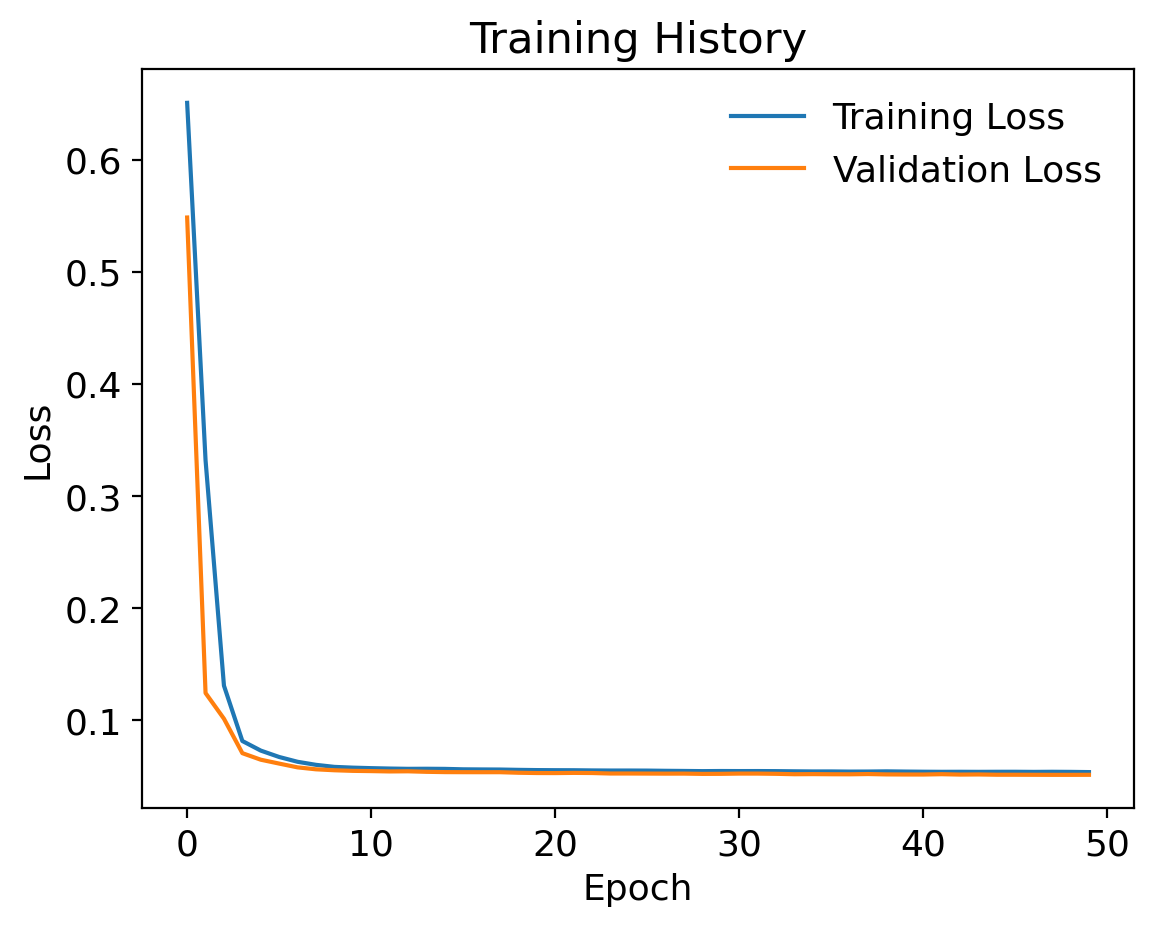

In [73]:
plot_history(train_losses_mse, val_losses_mse)

In [13]:
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [78]:
# Save the model  weightsto a pth file.
torch.save(model_mse.state_dict(), os.path.join(model_path,'CNN_model_bce_weights.pth'))

### 4. Evaluate the trained model

In [27]:
# make new model instances for evaluation (best practice)
model_mse_eval = SpatialCNN(in_channels=X_train.shape[1], n_filters=n_filters, activation=activation)
model_mae_eval = SpatialCNN(in_channels=X_train.shape[1], n_filters=n_filters, activation=activation)

# reload the saved model weights
state_dict_mse = torch.load(os.path.join(model_path,'CNN_model_bce_weights.pth'), weights_only=True)
model_mse_eval.load_state_dict(state_dict_mse)

# state_dict_mae = torch.load(os.path.join(model_path,'CNN_model_mae_weights.pth'), weights_only=True)
# model_mae_eval.load_state_dict(state_dict_mae)

<All keys matched successfully>

In [28]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model_mse_eval.to(device).eval()
predictions = []
with torch.no_grad():
   for batch_X, batch_y in test_loader:
       batch_X = batch_X.to(device)
       logits = model_mse_eval(batch_X)
       probs = torch.sigmoid(logits)
       predictions.append(probs.cpu().numpy())

y_test_mse_pre = np.concatenate(predictions, axis=0)
y_test_mse_pre = (y_test_mse_pre > 0.5).astype(np.float32)
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 141, 281)
y_test_mse_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                              'latitude': X_test_xr.latitude.values, 
                              'longitude': X_test_xr.longitude.values},
                      data_vars=dict(lightning=(['time', 'latitude', 'longitude'], y_test_mse_pre)))

First we check whether the ML model can capture the spatial distribution of global temperature

In [ ]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = ['2024-07-21T00:00:00', '2024-07-25T08:00:00', '2024-07-30T16:00:00']
vmin, vmax    = 0, 100
cmap = 'Purples'
y_test_mse_pre.lightning.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.lightning_density.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_mse_pre.lightning.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.lightning_density.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_mse_pre.lightning.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.lightning_density.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'lightning prediction (bce, {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'lightning truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

Text(0, 0.5, 'lightning')

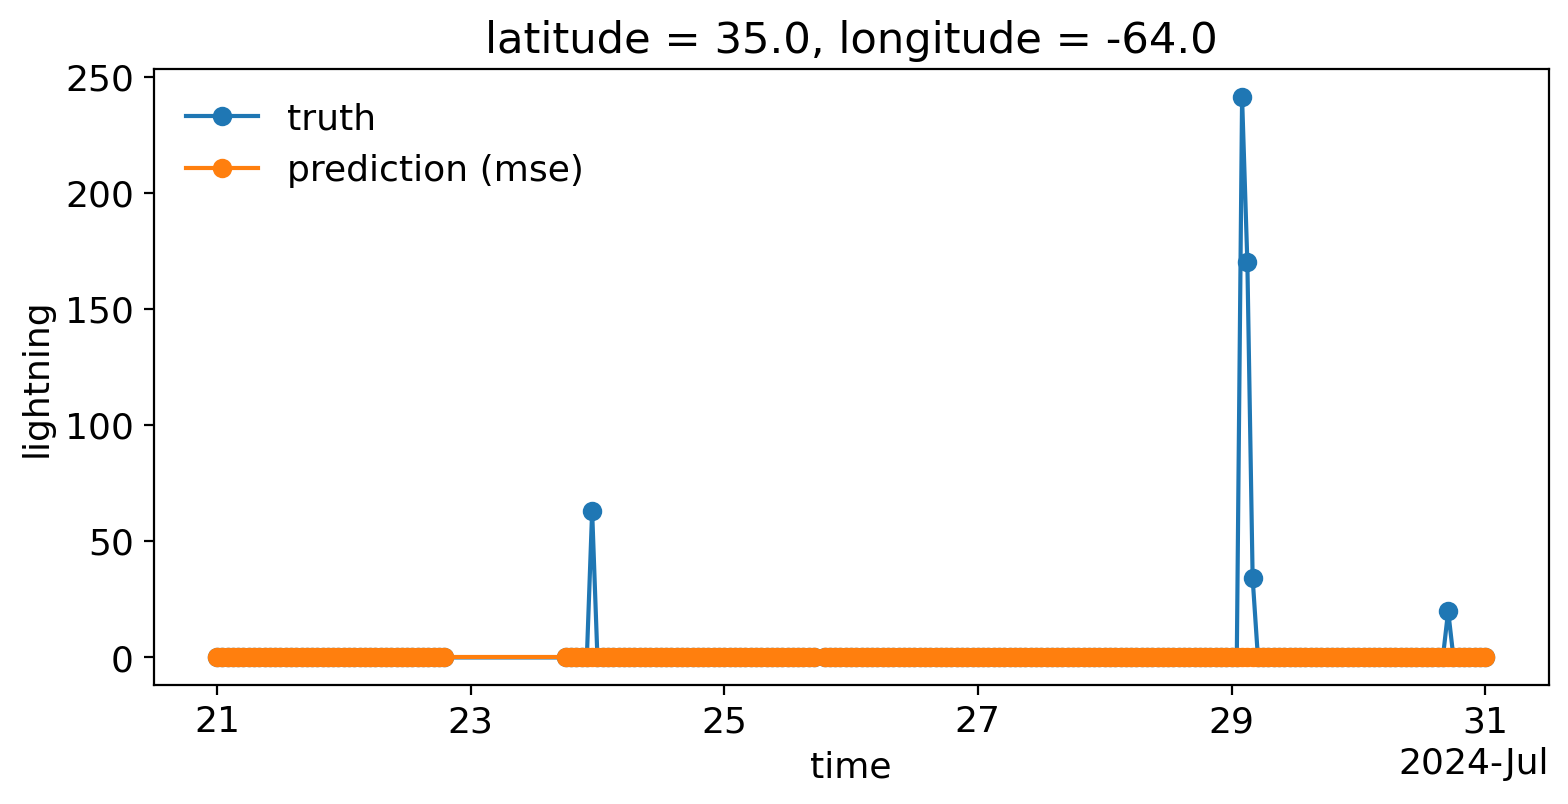

In [35]:
# NYC: 40.7128, -74.0060%360
# Rosalie Haus: 29.7395, -95.3720
# Tierra del Fuego: -54.301626, -67.400128

lat = 35
lon = -64

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').lightning_density.plot(marker='o',ax=ax,label='truth')
y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').lightning.plot(marker='o',ax=ax,label='prediction (mse)')
# y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:brown',label='prediction (mae)')

ax.legend()
ax.set_ylabel('lightning')

Let's check the statistical comparison between truth and prediction.

In [36]:
# combine truth and prediction arrays into a dataframe
nyc_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').lightning_density.values
nyc_test_mse_pre = y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').lightning.values
# nyc_test_mae_pre = y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values

df_nyc_test = pd.DataFrame()
df_nyc_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').lightning_density.to_dataframe().index
df_nyc_test["truth"] = nyc_test_xr
df_nyc_test["prediction_bce"] = nyc_test_mse_pre
# df_nyc_test["prediction_mae"] = nyc_test_mae_pre
print(df_nyc_test.head(10))

# summary statistics of the dataframe
df_nyc_test.describe()

                 time  truth  prediction_bce
0 2024-07-21 00:00:00    0.0             0.0
1 2024-07-21 01:00:00    0.0             0.0
2 2024-07-21 02:00:00    0.0             0.0
3 2024-07-21 03:00:00    0.0             0.0
4 2024-07-21 04:00:00    0.0             0.0
5 2024-07-21 05:00:00    0.0             0.0
6 2024-07-21 06:00:00    0.0             0.0
7 2024-07-21 07:00:00    0.0             0.0
8 2024-07-21 08:00:00    0.0             0.0
9 2024-07-21 09:00:00    0.0             0.0


,time,truth,prediction_bce
count,218,218.000000,218.0
mean,2024-07-26 06:38:15.412844032,2.422018,0.0
min,2024-07-21 00:00:00,0.000000,0.0
25%,2024-07-24 04:15:00,0.000000,0.0
50%,2024-07-26 11:30:00,0.000000,0.0
75%,2024-07-28 17:45:00,0.000000,0.0
max,2024-07-31 00:00:00,241.000000,0.0
std,NaN,20.503706,0.0


Finally we check whether the ML model can capture the time series of global average temperature 

In [ ]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

In [ ]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_mse_pre,label='prediction (mse)',ax=ax,color='tab:orange')
global_mean_std_plot(y_test_mae_pre,label='prediction (mae)',ax=ax,color='tab:brown')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
ax.legend()
plt.tight_layout()

In [ ]:
# get global mean temperature
def global_mean(X,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X['tas'].weighted(weights).mean(['latitude', 'longitude']).data
    return tas_mean

tas_mean_xr = global_mean(y_test_xr)
tas_mean_mse_pre = global_mean(y_test_mse_pre)
tas_mean_mae_pre = global_mean(y_test_mae_pre)

# put into dataframe
df_globalmean_test = pd.DataFrame()
df_globalmean_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_globalmean_test["truth"] = tas_mean_xr
df_globalmean_test["prediction_mse"] = tas_mean_mse_pre
df_globalmean_test["prediction_mae"] = tas_mean_mae_pre
print(df_globalmean_test.head(10))

# summary statistics of the dataframe
df_globalmean_test.describe()